# GMSAT trend significance testing

To do:  
Add in pooch features  
Generalise input (i.e., change names to be the same etc.)

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# analysis and plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from scipy.signal import butter, filtfilt
from scipy.stats import pearsonr

# stats
from scipy.stats import pearsonr

# systems
import os
from collections import defaultdict
import csv
import pooch

# plotting
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# my own functions and classes
from GMSAT_classes import Trend
from GMSAT_functions import CropTrendsDf, GenerateRN, GenerateWN, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, DictToDf

## Parameters

In [84]:
obsName = 'GISS'
N = 10

### Directories

#### Input

In [77]:
inputDir = '/home/hbyrne/Research/GMSAT_JS/Input'

#### Output

In [89]:
# Trends dataframes
pathBase = f'/home/hbyrne/Research/GMSAT_JS/Output_{obsName}/'
dirTrendsRNEnd = 'TrendsRN'
dirTrendsWNEnd = 'TrendsWN'

dirTrendsRN = pathBase + dirTrendsRNEnd
dirTrendsWN = pathBase + dirTrendsWNEnd

# time series stats
dirStatsEnd = 'TimeSeriesStats'
dirStats = pathBase + dirStatsEnd

## Calculating trends for real data

In [91]:
# taking a look at the file
inputFile = f'{obsName}.nc'

os.chdir(inputDir)
ds = xr.open_dataset(inputFile)

# standardising the input
if isinstance(ds.time.values[0], np.float64):
    dateIndex = pd.to_datetime(ds.time.values, format = '%Y')
    ds.coords['time'] = dateIndex

# calculating global mean sst based on this (note have to area weight the cells)
if obsName == 'GISS':
    weights = np.cos(np.radians(ds.lat))
    meanTemp = ds.tempanomaly.weighted(weights).mean(('lat', 'lon'), skipna = True)

if obsName == 'BEST':
    weights = np.cos(np.radians(ds.latitude))
    meanTemp = ds.temperature.weighted(weights).mean(('latitude', 'longitude'), skipna = True)

if obsName == 'HadCRUT':
    weights = np.cos(np.radians(ds.latitude))
    meanTemp = ds.tas_mean.weighted(weights).mean(('latitude', 'longitude'), skipna = True)

In [92]:
# aggregating to annual
meanTemp = meanTemp.groupby('time.year').mean(dim = 'time')

# now calculating the trends on this
trends = Trend(meanTemp)
trendsDict = trends.trends
trendsDf = trends.trendsDf

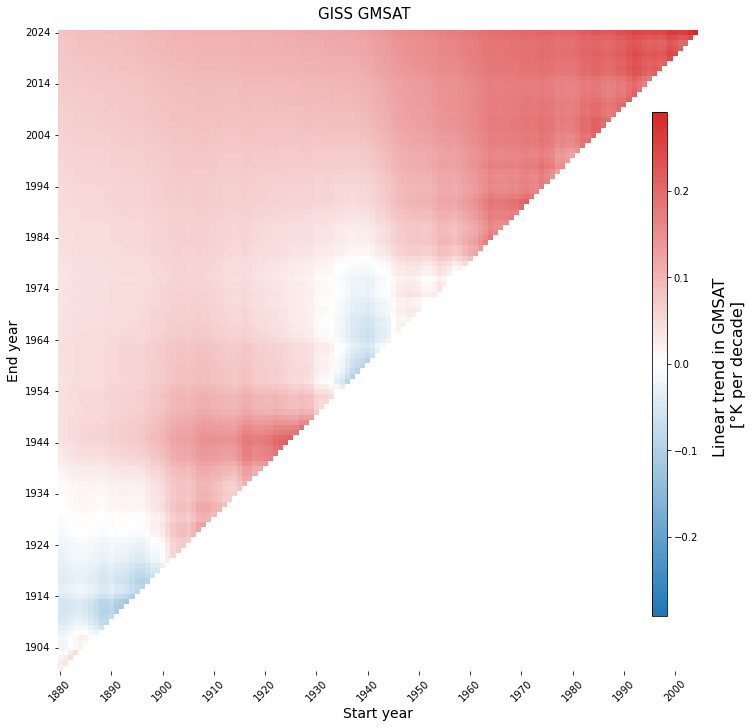

In [93]:
# plotting these trends

# first have to cut down the temp length
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# setting the colourbar
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
colors = [(0,'tab:blue'), (0.50,'white'), (1,'tab:red')]
cmap = mcolors.LinearSegmentedColormap.from_list('Blue_white_red', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, ax = plt.subplots(figsize = (10,10), constrained_layout = True)
fig.suptitle(f'{obsName} GMSAT', fontsize = 15)

ax.set_aspect('equal')
plot = sns.heatmap(trendsDfCrop, cmap = cmap, vmin = vmin, vmax = vmax, ax = ax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 14)
ax.set_xlabel('Start year', fontsize = 14)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in GMSAT \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

## Signifance testing: generating white noise with the same mean and variance

In [82]:
# detrending the meanTemp time series to get the standard deviation | using 60 year low pass | these values seem to produce a line similar to the temp data

# ----------------------------
#      Defining the filter
# ----------------------------

# defining the cutoff frequency
cutoff = 60 # years
freqCutoff = 1/cutoff

# defining the parameters for the filter
order = 3 # trying different values
fs = 1

# building the filter
b, a = butter(order, freqCutoff, btype = 'low', analog = False, output = 'ba', fs = fs)

# filtering
meanTempFilt = filtfilt(b, a, meanTemp)

# ----------------------------
#      Detrending the data
# ----------------------------

meanTempDetrended = meanTemp - meanTempFilt

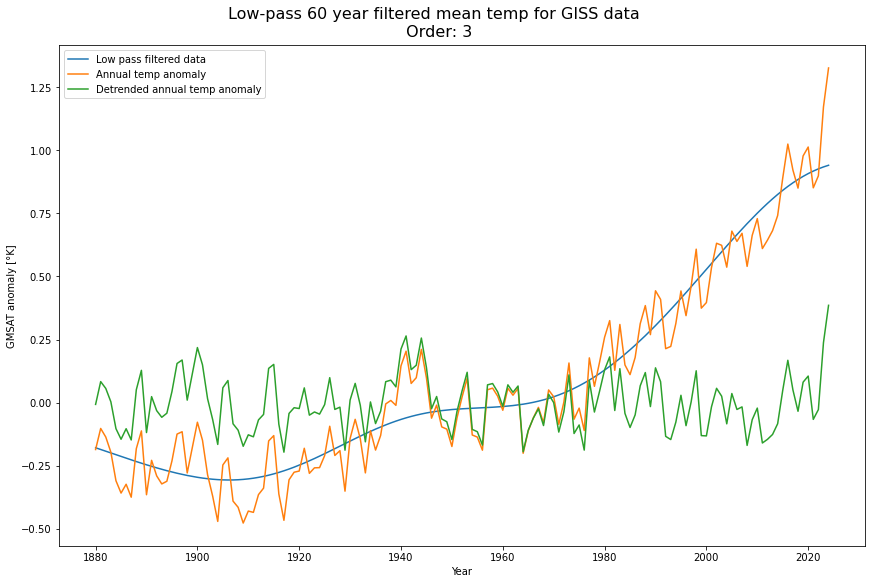

In [83]:
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'Low-pass {cutoff} year filtered mean temp for {obsName} data \n Order: {order}', fontsize = 16)
plt.plot(meanTemp.year, meanTempFilt, label = 'Low pass filtered data')
plt.plot(meanTemp.year, meanTemp, label = 'Annual temp anomaly')
plt.plot(meanTemp.year, meanTempDetrended, label = 'Detrended annual temp anomaly')
ax.set_ylabel('GMSAT anomaly [°K]')
ax.set_xlabel('Year')
plt.legend()
plt.show()

In [40]:
# creating 1000 red and white noise time series and calculating the trends for them

# initialise dictionary to hold the trends
dictTrendsWN = defaultdict(list)
dictTrendsRN = defaultdict(list)

# calculating the meanTemp values
meanTempMean = meanTempDetrended.mean().item()
meanTempStd = meanTempDetrended.std().item()

# initialise lists to hold the std and mean values as well
listMeanWN = []
listStdWN = []
listMeanRN = []
listStdRN = []

for n in range(N):

    # generate the time series
    whiteNoise = GenerateWN(meanTemp, meanTempMean, meanTempStd)
    redNoise = GenerateWN(meanTemp, meanTempMean, meanTempStd)

    # saving out the mean and std of both of these just to check that they were actually right
    listStdWN.append(whiteNoise.std().item())
    listMeanWN.append(whiteNoise.mean().item())
    listStdRN.append(redNoise.std().item())
    listMeanRN.append(redNoise.mean().item())

    # calculating trends on these
    trendsDfWN = Trend(whiteNoise).trendsDf
    trendsDfRN = Trend(redNoise).trendsDf
    
    # saving the trends to output files
    os.chdir(dirTrendsWN)
    fileName = (f'Trend_WN_{n}.csv')
    trendsDfWN.to_csv(fileName, index = True)

    os.chdir(dirTrendsRN)
    fileName = (f'Trend_RN_{n}.csv')
    trendsDfRN.to_csv(fileName, index = True)

    print(f'{n} / {N}')

# saving out the csv files
os.chdir(dirStats)

with open('Mean_WN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listMeanWN)
    
with open('STD_WN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listStdWN)
    
with open('Mean_RN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listMeanRN)
    
with open('STD_RN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listStdRN)

KeyboardInterrupt: 

## Reading files back in and calculating obs in range

In [12]:
# reading files back in
os.chdir(dirTrendsWN)
dictTrendsWN = TrendsDictFromFiles(dirTrendsWN)

os.chdir(dirTrendsRN)
dictTrendsRN = TrendsDictFromFiles(dirTrendsRN)

# calculate upper and lower values
dictLowerWN, dictUpperWN = CalculateTrendPercentile(dictTrendsWN, 2.5, 97.5)
dictLowerRN, dictUpperRN = CalculateTrendPercentile(dictTrendsRN, 2.5, 97.5)

# find the values in range
dictDataInRangeWN = FlagInRange(dictLowerWN, dictUpperWN, trendsDict)
dictDataInRangeRN = FlagInRange(dictLowerRN, dictUpperRN, trendsDict)

# convert to dataframes
dfDataInRangeWN = DictToDf(dictDataInRangeWN)
dfDataInRangeRN = DictToDf(dictDataInRangeRN)

### Plotting

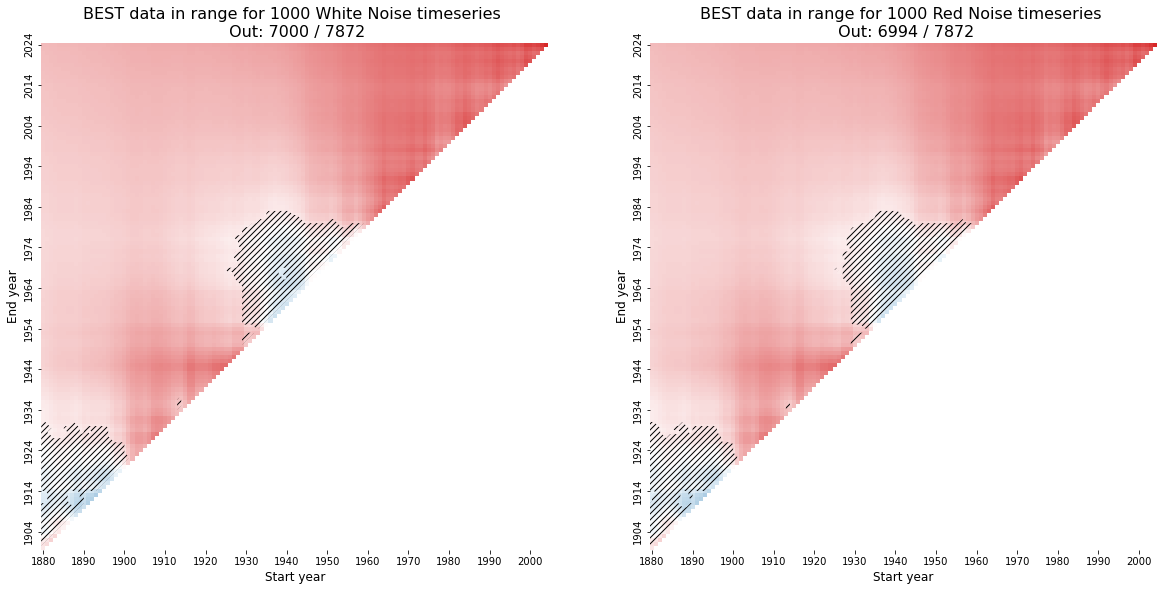

In [74]:
# plotting for in and out of range

# __Universal attributes___
nFigures = 2
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 10)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

# trimming the obs data
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# setting the colourbar
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
colors = [(0,'tab:blue'), (0.50,'white'), (1,'tab:red')]
cmap = mcolors.LinearSegmentedColormap.from_list('Blue_white_red', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(nRows, nCols, figsize = (figWidth, figHeight))

# counting data points in and out for both
countOutWN = list(dictDataInRangeWN.values()).count(0)
countAllWN = list(dictDataInRangeWN.values()).count(1) + countOutWN

countOutRN = list(dictDataInRangeRN.values()).count(0)
countAllRN = list(dictDataInRangeRN.values()).count(1) + countOutRN

# counting the number of time series involved
numberWN = len(dictTrendsWN[list(dictTrendsWN.keys())[0]])
numberRN = len(dictTrendsRN[list(dictTrendsRN.keys())[0]])

# ______________plotting white noise_______________

axes[0].set_aspect('equal')
axes[0].set_title(f'{obsName} data in range for {numberWN} White Noise timeseries \n Out: {countOutWN} / {countAllWN}', fontsize = 16)
plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = axes[0], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
axes[0].set_ylabel('End year', fontsize = 12)
axes[0].set_xlabel('Start year', fontsize = 12)

#for a, row in enumerate(dfDataInRangeWN.values):
#        for b, value in enumerate(row):
#            if value == 1:
#                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=False, edgecolor='black', hatch='////'))

axes[0].contourf(dfDataInRangeWN,levels=[0.5, 1.5], colors='none', hatches=['////'], extend='lower')

# ______________plotting red noise_______________

axes[1].set_aspect('equal')
axes[1].set_title(f'{obsName} data in range for {numberRN} Red Noise timeseries \n Out: {countOutRN} / {countAllRN}', fontsize = 16)
plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = axes[1], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
axes[1].set_ylabel('End year', fontsize = 12)
axes[1].set_xlabel('Start year', fontsize = 12)

axes[1].contourf(dfDataInRangeRN,levels=[0.5, 1.5], colors='none', hatches=['////'], extend='lower')

plt.show()

### Looking at the stats

In [14]:
os.chdir(dirStats)
fileNames = ['Mean_WN.csv', 'Mean_RN.csv', 'STD_WN.csv', 'STD_RN.csv']
fields = ['Mean_WN', 'Mean_RN', 'STD_WN', 'STD_RN']

# creating a 2 d array to store the values
stats = pd.read_csv(fileNames[0], header = None)

for fileNum in range(1,len(fileNames)):
    file = pd.read_csv(fileNames[fileNum], header = None)
    stats = pd.concat([stats, file])

stats['Field'] = fields
stats = stats.set_index('Field', drop = True);

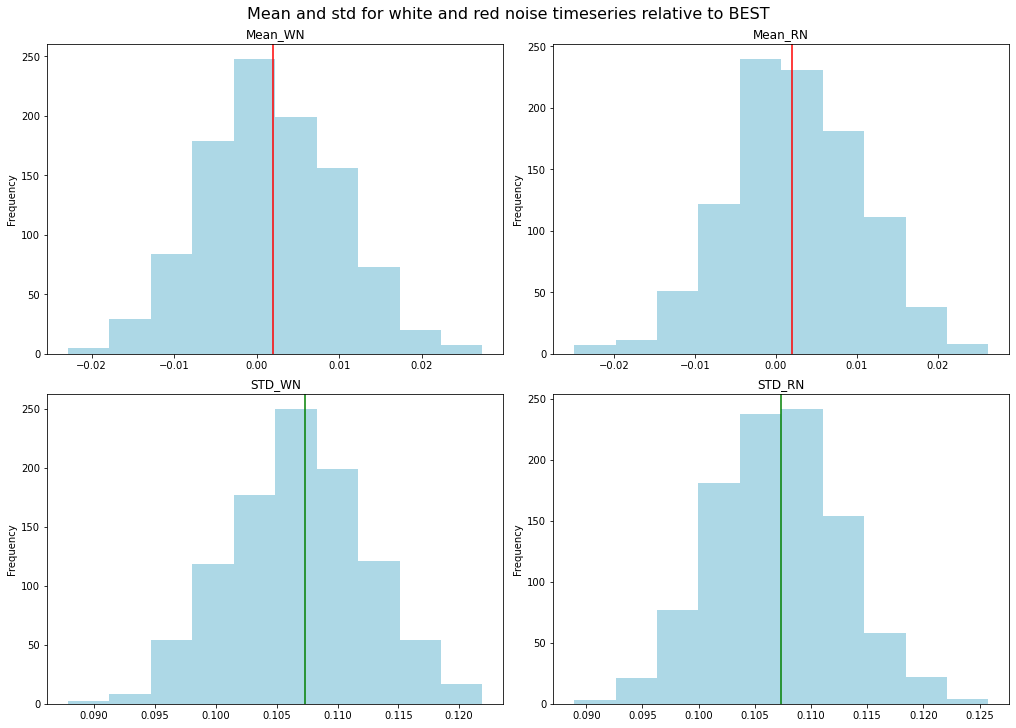

In [15]:
# plotting this and them mean values from the GISS dataset
fig, axes = plt.subplots(2,2, figsize = (14,10), constrained_layout = True)
axes_flat = axes.flatten()
fig.suptitle('Mean and std for white and red noise timeseries relative to BEST', fontsize = 16)

for i in range(len(fileNames)):
    axes_flat[i].set_title(fields[i], fontsize = 12)
    stats.iloc[i].plot.hist(ax = axes_flat[i], color = 'lightblue')
    
# getting the values from the real dataset
meanTempMean = meanTempDetrended.mean().item()
meanTempStd = meanTempDetrended.std().item()

# plotting these as reference lines
axes_flat[0].axvline(x = meanTempMean, color = 'r')
axes_flat[1].axvline(x = meanTempMean, color = 'r')
axes_flat[2].axvline(x = meanTempStd, color = 'g')
axes_flat[3].axvline(x = meanTempStd, color = 'g')

plt.show()

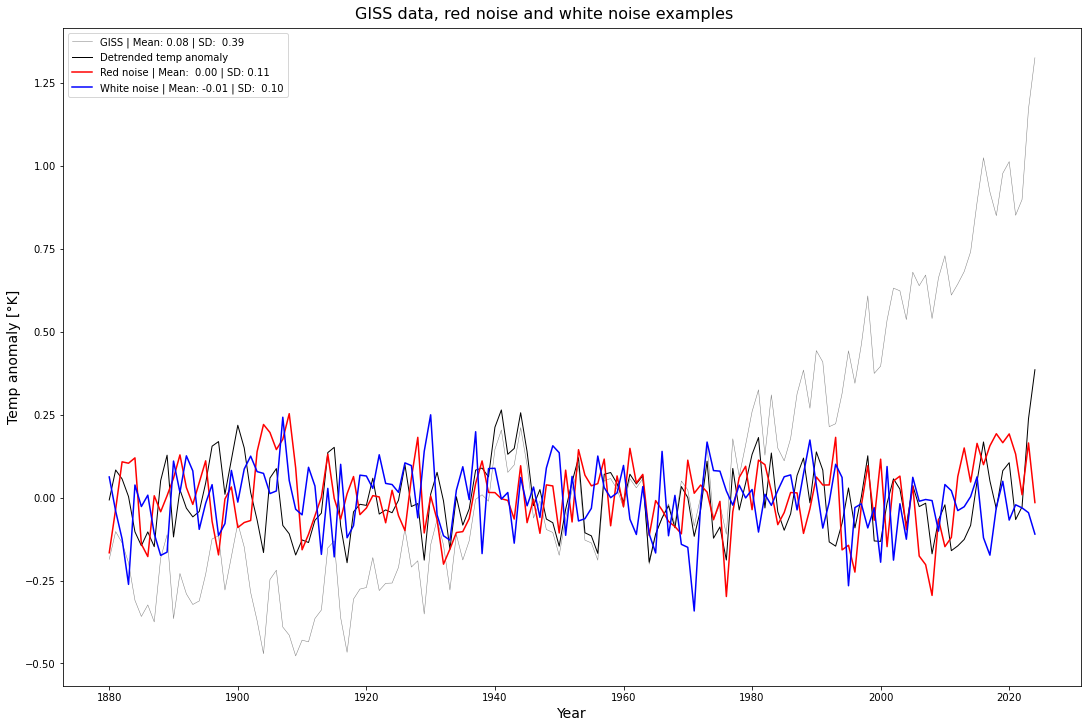

In [95]:
fig, ax = plt.subplots(figsize = (15,10), constrained_layout = True)
fig.suptitle(f'{obsName} data, red noise and white noise examples', fontsize = 16)

meanTemp.plot(label = f'{obsName} | Mean: {meanTemp.mean().item():.2f} | SD: {meanTemp.std().item(): .2f}', color = 'gray', linewidth = 0.5)
meanTempDetrended.plot(label = f'Detrended temp anomaly', color = 'black', linewidth = 1)
plotRN = GenerateRN(meanTempDetrended, meanTempMean, meanTempStd)
plotRN.plot(label = f'Red noise | Mean: {plotRN.mean().item(): .2f} | SD: {plotRN.std().item() :.2f}', color = 'red', linewidth = 1.5)
plotWN = GenerateWN(meanTempDetrended, meanTempMean, meanTempStd)
plotWN.plot(label = f'White noise | Mean: {plotWN.mean().item():.2f} | SD: {plotWN.std().item(): .2f}', color = 'blue', linewidth = 1.5)

ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Temp anomaly [°K]', fontsize = 14)
plt.legend()

plt.show()